# Demo of Unbalanced JEs and Completness Test

In [1]:
# Imports
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from dask.distributed import Client

In [2]:
# Start DASK
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 61.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45969,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 61.91 GiB
Comm: tcp://127.0.0.1:35079,Total threads: 4
Dashboard: http://127.0.0.1:44241/status,Memory: 7.74 GiB
Nanny: tcp://127.0.0.1:33981,


## Read in Data

In [3]:
# Read TB data
source_tb = '../data/trail_balance_13_788.parquet'
ddf_tb = dd.read_parquet(source_tb)

In [4]:
# Read GL Data (23,5469 Rows)
source_gl = '../data/general_ledger_235_469.parquet'
ddf_gl = dd.read_parquet(source_gl)

In [5]:
# Nothing is read in yet, just a placeholding for planning.
ddf_tb

<dask_expr.expr.DataFrame: expr=ReadParquet(173111b)>

In [6]:
ddf_tb.dtypes

TB_Business_Unit_Code         object
TB_Fiscal_Year                object
TB_Account_Number             object
TB_Amount_Opening_Balance    float64
TB_Amount_Ending_Balance     float64
dtype: object

In [7]:
ddf_tb.values

dask.array<values, shape=(nan, 5), dtype=object, chunksize=(nan, 5), chunktype=numpy.ndarray>

In [8]:
ddf_tb.head()

,TB_Business_Unit_Code,TB_Fiscal_Year,TB_Account_Number,TB_Amount_Opening_Balance,TB_Amount_Ending_Balance
0,1000,0000,0000000015,-3.959946e+07,-3.959946e+07
1,1000,0000,0000000035,4.000000e+04,4.000000e+04
2,1000,0000,0000000078,-3.154201e+08,-3.154201e+08
3,1000,0000,0000000195,0.000000e+00,-3.802560e+05
4,1000,0000,0000000204,1.232493e+05,1.232493e+05


In [9]:
ddf_gl

<dask_expr.expr.DataFrame: expr=ReadParquet(b4643e7)>

In [10]:
ddf_gl.dtypes

GL_Business_Unit_Code     object
GL_Doc_Number             object
GL_Fiscal_Year            object
GL_Line_Number            object
GL_Effective_Date         object
GL_Account_Number         object
GL_Local_Amount          float64
GL_Journal_ID             object
dtype: object

In [11]:
ddf_gl.values

dask.array<values, shape=(nan, 8), dtype=object, chunksize=(nan, 8), chunktype=numpy.ndarray>

In [12]:
ddf_gl.head()

,GL_Business_Unit_Code,GL_Doc_Number,GL_Fiscal_Year,GL_Line_Number,GL_Effective_Date,GL_Account_Number,GL_Local_Amount,GL_Journal_ID
0,4000,0000004878,0000,001,0000-01-01,0000000004,28166.55,4000-0000004878-0000
1,4000,0000004878,0000,002,0000-01-01,0000000177,-28166.55,4000-0000004878-0000
2,1000,0000019963,0000,001,0000-01-05,0000000208,6490.60,1000-0000019963-0000
3,1000,0000019963,0000,002,0000-01-05,0000000155,-6490.60,1000-0000019963-0000
4,1000,0000019963,0000,003,0000-01-05,0000000208,5940.00,1000-0000019963-0000


## Find Unblanced JE

In [13]:
# Get JE totals
ddf_gl_je_total = ddf_gl.groupby(by='GL_Journal_ID')[['GL_Local_Amount']].sum()

In [14]:
# Get Unbalanced JEs
ddf_gl_unbalanced_je = ddf_gl_je_total[ddf_gl_je_total.abs().round(2) > 0]

In [15]:
# Get Unbalanced Lines
ddf_gl_unbalanced_lines = dd.merge(
    left=ddf_gl,
    right=ddf_gl_unbalanced_je,
    how='inner',
    left_on='GL_Journal_ID',
    right_index=True,
    suffixes=(None,'_y'),
)

In [16]:
# Filter just for the columns we want
columns = ['GL_Journal_ID', 'GL_Line_Number', 'GL_Effective_Date', 'GL_Account_Number', 'GL_Local_Amount']
ddf_unbalanced_lines_report = ddf_gl_unbalanced_lines[columns]

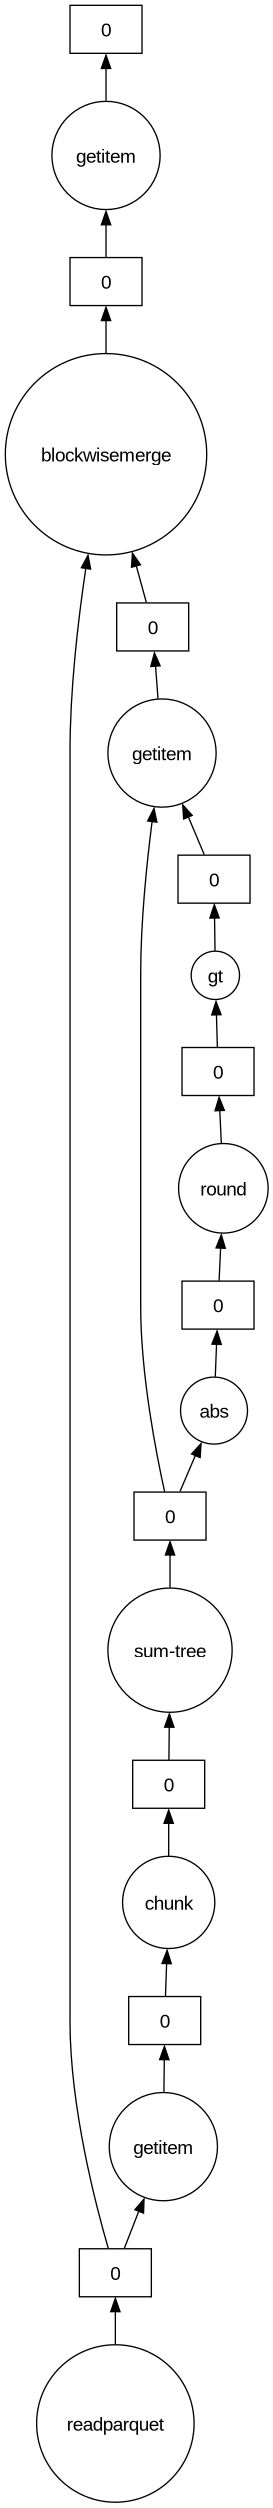

In [17]:
# What is DASK going to do?
dask.visualize(ddf_unbalanced_lines_report)

In [18]:
# Lets get a local copy so we can play with the data
df_unbalanced_lines_report_local = ddf_unbalanced_lines_report.compute()
df_unbalanced_lines_report_local

,GL_Journal_ID,GL_Line_Number,GL_Effective_Date,GL_Account_Number,GL_Local_Amount
0,4000-0000004878-0000,001,0000-01-01,0000000004,28166.55
1,4000-0000004878-0000,002,0000-01-01,0000000177,-28166.55
2,1000-0000019963-0000,001,0000-01-05,0000000208,6490.60
3,1000-0000019963-0000,002,0000-01-05,0000000155,-6490.60
4,1000-0000019963-0000,003,0000-01-05,0000000208,5940.00
...,...,...,...,...,...
235464,6000-0000006881-0000,139,0000-12-31,0000000225,0.00
235465,6000-0000006881-0000,140,0000-12-31,0000000248,0.00
235466,6000-0000006881-0000,141,0000-12-31,0000000225,0.00
235467,6000-0000006881-0000,142,0000-12-31,0000000248,0.00


## Do a Completness Check 

In [19]:
# Summaraize GL by account number
gl_groupby_columns = ['GL_Fiscal_Year','GL_Business_Unit_Code','GL_Account_Number']
ddf_gl_by_account = ddf_gl.groupby(by=gl_groupby_columns)[['GL_Local_Amount']].sum().reset_index()

In [20]:
# Summaraize TB by account number
tb_groupby_columns = ['TB_Fiscal_Year','TB_Business_Unit_Code','TB_Account_Number']
tb_amount_columns = ['TB_Amount_Opening_Balance','TB_Amount_Ending_Balance']
ddf_tb_by_account = ddf_tb.groupby(by=tb_groupby_columns)[tb_amount_columns].sum().reset_index()

In [21]:
# Combine GL and TB data
ddf_gl_tb_by_account = dd.merge(
    left=ddf_gl_by_account,
    right=ddf_tb_by_account,
    how='outer',
    left_on=gl_groupby_columns,
    right_on=tb_groupby_columns,
)

In [22]:
# Compute any completness differances
ddf_gl_tb_by_account['Differance'] = (
    ddf_gl_tb_by_account['TB_Amount_Opening_Balance'] 
    + ddf_gl_tb_by_account['GL_Local_Amount'] 
    - ddf_gl_tb_by_account['TB_Amount_Ending_Balance']
)

In [23]:
# Filter just for the columns we want and cleanup column names
column_map = {
    'TB_Fiscal_Year': 'Fiscal_Year',
    'TB_Business_Unit_Code': 'Business_Unit_Code',
    'TB_Account_Number': 'Account_Number',
    'TB_Amount_Opening_Balance': 'Opening_Balance',
    'GL_Local_Amount': 'Activity',
    'TB_Amount_Ending_Balance': 'Ending_Balance',
    'Differance': 'Differance',
}

ddf_completness_report = ddf_gl_tb_by_account[list(column_map.keys())].rename(columns=column_map)

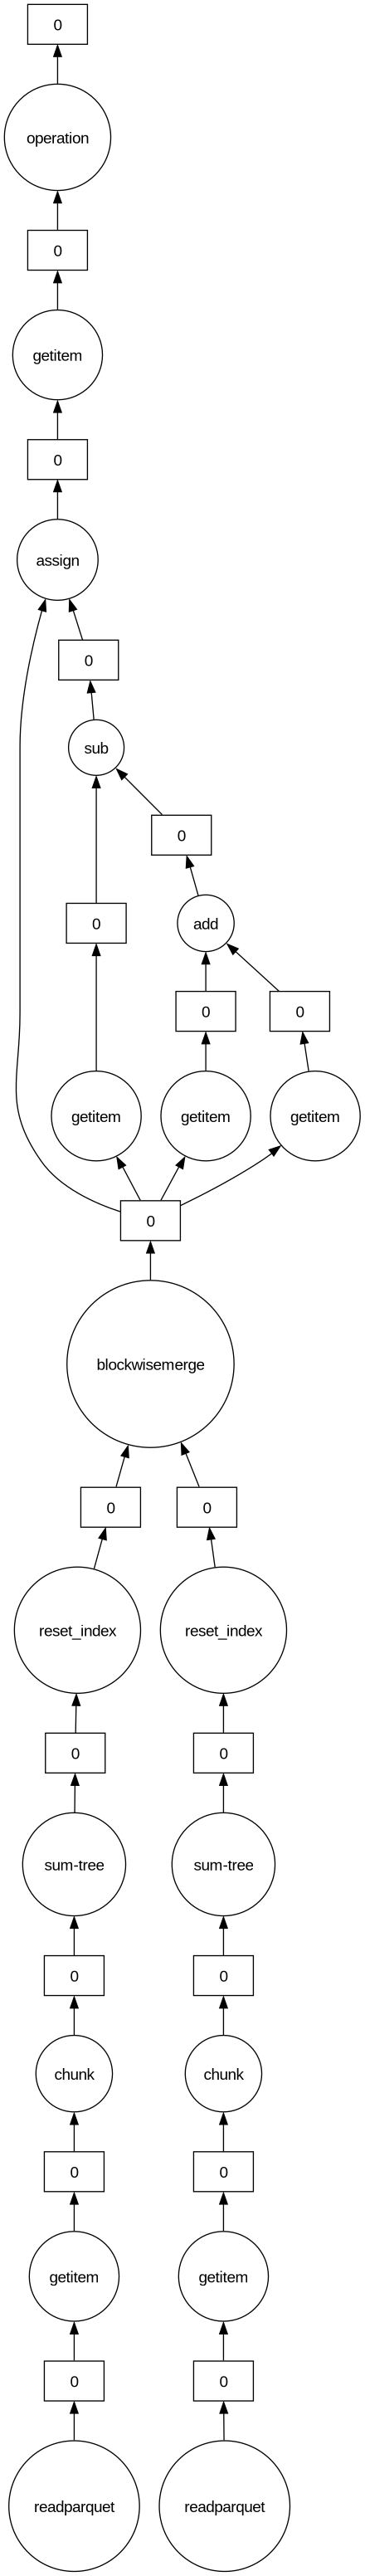

In [24]:
# What is DASK going to do?
dask.visualize(ddf_completness_report)

In [25]:
# Lets get a local copy so we can play with the data
df_completness_report_local = ddf_completness_report.compute()
df_completness_report_local

,Fiscal_Year,Business_Unit_Code,Account_Number,Opening_Balance,Activity,Ending_Balance,Differance
0,0000,1000,0000000000,1.592439e+09,NaN,1.592439e+09,NaN
1,0000,1000,0000000001,-3.758600e+08,-1182825.0,-3.782257e+08,1182825.0
2,0000,1000,0000000002,1.714749e+08,NaN,1.714749e+08,NaN
3,0000,1000,0000000003,-1.505509e+08,-313234.0,-1.511773e+08,313234.0
4,0000,1000,0000000004,6.475901e+07,NaN,6.475901e+07,NaN
...,...,...,...,...,...,...,...
1148,0000,6000,0000000304,0.000000e+00,0.0,0.000000e+00,0.0
1149,0000,6000,0000000305,0.000000e+00,0.0,0.000000e+00,0.0
1150,0000,6000,0000000306,0.000000e+00,NaN,0.000000e+00,NaN
1151,0000,6000,0000000309,0.000000e+00,NaN,0.000000e+00,NaN


## Run Unblanced JE & Do a Completness Check

To be more effent, don't read the data in twice and run Unblanced JE and Completness seperatly.  Run them both at the same time so the same data does not need to be read in twice

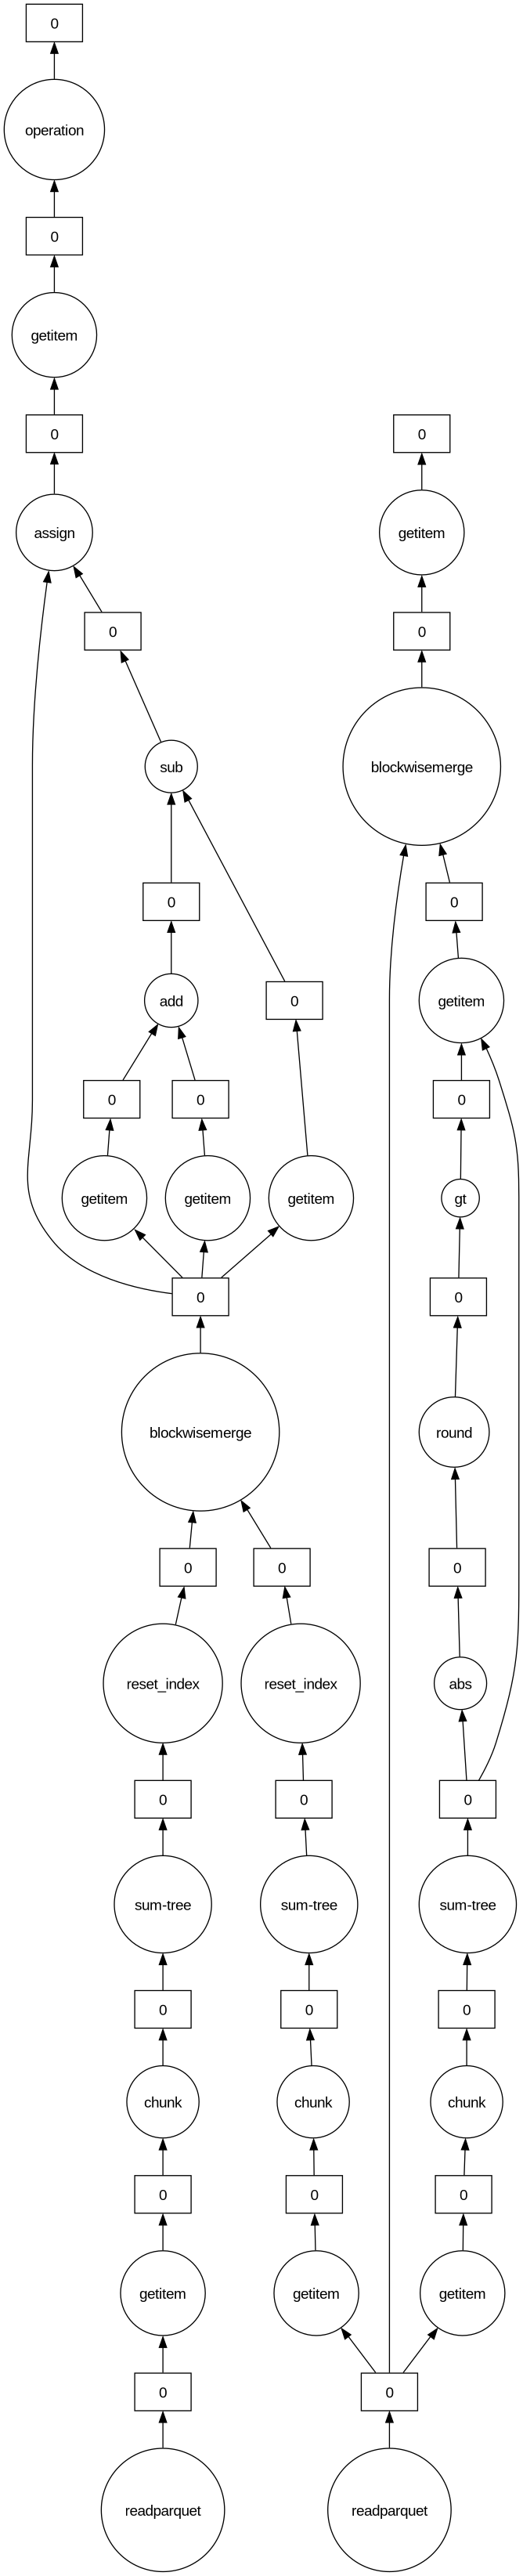

In [26]:
# View plan to compute Unblanced JE and Completness together (simplify for readability)
dask.visualize(
    ddf_unbalanced_lines_report,
    ddf_completness_report,
)

In [27]:
# Compute Unblanced JE and Completness at once
df_unbalanced_lines_report_local, df_completness_report_local = dask.compute(
    ddf_unbalanced_lines_report,
    ddf_completness_report,
)

In [28]:
# View unbalanced JEs
df_unbalanced_lines_report_local

,GL_Journal_ID,GL_Line_Number,GL_Effective_Date,GL_Account_Number,GL_Local_Amount
0,4000-0000004878-0000,001,0000-01-01,0000000004,28166.55
1,4000-0000004878-0000,002,0000-01-01,0000000177,-28166.55
2,1000-0000019963-0000,001,0000-01-05,0000000208,6490.60
3,1000-0000019963-0000,002,0000-01-05,0000000155,-6490.60
4,1000-0000019963-0000,003,0000-01-05,0000000208,5940.00
...,...,...,...,...,...
235464,6000-0000006881-0000,139,0000-12-31,0000000225,0.00
235465,6000-0000006881-0000,140,0000-12-31,0000000248,0.00
235466,6000-0000006881-0000,141,0000-12-31,0000000225,0.00
235467,6000-0000006881-0000,142,0000-12-31,0000000248,0.00


In [29]:
# View Complteness
df_completness_report_local

,Fiscal_Year,Business_Unit_Code,Account_Number,Opening_Balance,Activity,Ending_Balance,Differance
0,0000,1000,0000000000,1.592439e+09,NaN,1.592439e+09,NaN
1,0000,1000,0000000001,-3.758600e+08,-1182825.0,-3.782257e+08,1182825.0
2,0000,1000,0000000002,1.714749e+08,NaN,1.714749e+08,NaN
3,0000,1000,0000000003,-1.505509e+08,-313234.0,-1.511773e+08,313234.0
4,0000,1000,0000000004,6.475901e+07,NaN,6.475901e+07,NaN
...,...,...,...,...,...,...,...
1148,0000,6000,0000000304,0.000000e+00,0.0,0.000000e+00,0.0
1149,0000,6000,0000000305,0.000000e+00,0.0,0.000000e+00,0.0
1150,0000,6000,0000000306,0.000000e+00,NaN,0.000000e+00,NaN
1151,0000,6000,0000000309,0.000000e+00,NaN,0.000000e+00,NaN


# Stress Testing with 100 Million Rows of Data

## Read in Data (100M)

In [30]:
# Read TB data
ddf_tb = dd.read_parquet('../data/trail_balance_5_997_780.parquet/')

# Read GL Data (100,000,000 Rows)
ddf_gl = dd.read_parquet('../data/general_ledger_100_074_325.parquet/')

## Find Unblanced JE (100M)

In [31]:
# Get JE totals
ddf_gl_je_total = ddf_gl.groupby(by='GL_Journal_ID')[['GL_Local_Amount']].sum()

# Get Unbalanced JEs
dfd_gl_unbalanced_je = ddf_gl_je_total[ddf_gl_je_total.abs().round(2) > 0]

# Get Unbalanced Lines
ddf_gl_unbalanced_lines = dd.merge(
    left=ddf_gl,
    right=ddf_gl_unbalanced_je,
    how='inner',
    left_on='GL_Journal_ID',
    right_index=True,
    suffixes=(None,'_y'),
)

# Filter just for the columns we want
columns = ['GL_Journal_ID', 'GL_Line_Number', 'GL_Effective_Date', 'GL_Account_Number', 'GL_Local_Amount']
ddf_unbalanced_lines_report = ddf_gl_unbalanced_lines[columns]

## Do a Completness Check  (100M)

In [32]:
# Summaraize GL by account number
gl_groupby_columns = ['GL_Fiscal_Year','GL_Business_Unit_Code','GL_Account_Number']
ddf_gl_by_account = ddf_gl.groupby(by=gl_groupby_columns)[['GL_Local_Amount']].sum().reset_index()

# Summaraize TB by account number
tb_groupby_columns = ['TB_Fiscal_Year','TB_Business_Unit_Code','TB_Account_Number']
tb_amount_columns = ['TB_Amount_Opening_Balance','TB_Amount_Ending_Balance']
ddf_tb_by_account = ddf_tb.groupby(by=tb_groupby_columns)[tb_amount_columns].sum().reset_index()

# Combine GL and TB data
ddf_gl_tb_by_account = dd.merge(
    left=ddf_gl_by_account,
    right=ddf_tb_by_account,
    how='outer',
    left_on=gl_groupby_columns,
    right_on=tb_groupby_columns,
)

# Compute any completness differances
ddf_gl_tb_by_account['Differance'] = (
    ddf_gl_tb_by_account['TB_Amount_Opening_Balance'] 
    + ddf_gl_tb_by_account['GL_Local_Amount'] 
    - ddf_gl_tb_by_account['TB_Amount_Ending_Balance']
)

# Filter just for the columns we want and cleanup column names
column_map = {
    'TB_Fiscal_Year': 'Fiscal_Year',
    'TB_Business_Unit_Code': 'Business_Unit_Code',
    'TB_Account_Number': 'Account_Number',
    'TB_Amount_Opening_Balance': 'Opening_Balance',
    'GL_Local_Amount': 'Activity',
    'TB_Amount_Ending_Balance': 'Ending_Balance',
    'Differance': 'Differance',
}

ddf_completness_report = ddf_gl_tb_by_account[list(column_map.keys())].rename(columns=column_map)

## Run Unblanced JE & Do a Completness Check (100M)

In [33]:
%%time
# Compute Unblanced JE and Completness
df_unbalanced_lines_report_local, df_completness_report_local = dask.compute(
    ddf_unbalanced_lines_report,
    ddf_completness_report,
)

CPU times: user 1.64 s, sys: 181 ms, total: 1.82 s
Wall time: 8.7 s


In [34]:
# View unbalanced JEs
df_unbalanced_lines_report_local

,GL_Journal_ID,GL_Line_Number,GL_Effective_Date,GL_Account_Number,GL_Local_Amount
0,1000-0000006893-0000,001,0000-01-05,0000000096,34.96
1,1000-0000006893-0000,002,0000-01-05,0000000290,-30.14
2,1000-0000006893-0000,003,0000-01-05,0000000124,-4.82
30,1000-0000006894-0000,001,0000-01-05,0000000096,4.37
31,1000-0000006894-0000,002,0000-01-05,0000000290,-3.77
...,...,...,...,...,...
2354641,6000-0000013835-0000,002,0000-01-29,0000000111,0.00
2354660,6000-0000013836-0000,001,0000-01-29,0000000266,0.00
2354661,6000-0000013836-0000,002,0000-01-29,0000000111,0.00
2354680,6000-0000013837-0000,001,0000-01-29,0000000215,0.00


In [35]:
# View Complteness
df_completness_report_local

,Fiscal_Year,Business_Unit_Code,Account_Number,Opening_Balance,Activity,Ending_Balance,Differance
0,0000,1000,0000000000,1.592439e+09,NaN,1.592439e+09,NaN
1,0000,1000,0000000001,-3.758600e+08,-1182825.0,-3.782257e+08,1182825.0
2,0000,1000,0000000002,1.714749e+08,NaN,1.714749e+08,NaN
3,0000,1000,0000000003,-1.505509e+08,-313234.0,-1.511773e+08,313234.0
4,0000,1000,0000000004,6.475901e+07,NaN,6.475901e+07,NaN
...,...,...,...,...,...,...,...
501550,0434,6000,0000000304,0.000000e+00,0.0,0.000000e+00,0.0
501551,0434,6000,0000000305,0.000000e+00,0.0,0.000000e+00,0.0
501552,0434,6000,0000000306,0.000000e+00,NaN,0.000000e+00,NaN
501553,0434,6000,0000000309,0.000000e+00,NaN,0.000000e+00,NaN


## Business Case: What issue does this address?
We were just able to process 100 million rows of data on my local laptop with no issues around the volume of the data, the limited number of cores, or the limited amout of RAM.

## Turn DASK off

In [36]:
client.shutdown()